In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

c:\users\nguye\anaconda3\envs\cuongnguyen_env\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [ ]:
!pip install python-Levenshtein

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Setting

In [3]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 10 #8
BATCH_SIZE = 512

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [4]:
dataset_filename = os.listdir("./data")[0]
dataset_path = os.path.join(".","data",dataset_filename)
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)
print("Dataset size:", len(df))

Open file: .\data\training.1600000.processed.noemoticon.csv
Dataset size: 1600000


In [5]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [6]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [7]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

Wall time: 358 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

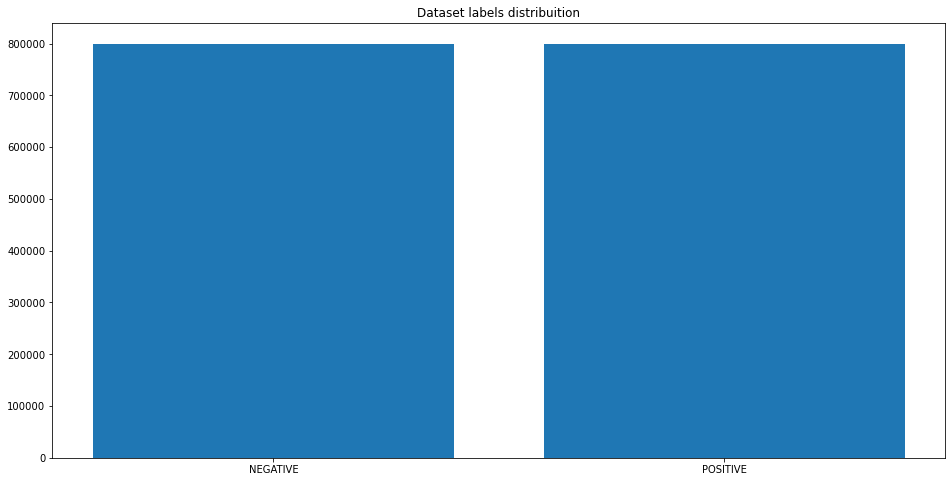

In [8]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [9]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [10]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [11]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

Wall time: 42.9 s


### Split train and test

In [12]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


### Word2Vec 

In [13]:
%%time
documents = [_text.split() for _text in df_train.text] 

Wall time: 2.84 s


In [14]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

2021-06-26 19:39:44,062 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=300, alpha=0.025)', 'datetime': '2021-06-26T19:39:44.062713', 'gensim': '4.0.1', 'python': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}


In [15]:
w2v_model.build_vocab(documents)

2021-06-26 19:39:44,076 : INFO : collecting all words and their counts
2021-06-26 19:39:44,077 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-06-26 19:39:44,094 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2021-06-26 19:39:44,110 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2021-06-26 19:39:44,129 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2021-06-26 19:39:44,145 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2021-06-26 19:39:44,163 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2021-06-26 19:39:44,182 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2021-06-26 19:39:44,199 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2021-06-26 19:39:44,217 : INFO : PROGRESS: at s

2021-06-26 19:39:45,446 : INFO : PROGRESS: at sentence #720000, processed 5193881 words, keeping 200325 word types
2021-06-26 19:39:45,463 : INFO : PROGRESS: at sentence #730000, processed 5265467 words, keeping 202133 word types
2021-06-26 19:39:45,481 : INFO : PROGRESS: at sentence #740000, processed 5337518 words, keeping 203818 word types
2021-06-26 19:39:45,499 : INFO : PROGRESS: at sentence #750000, processed 5409321 words, keeping 205535 word types
2021-06-26 19:39:45,519 : INFO : PROGRESS: at sentence #760000, processed 5481512 words, keeping 207282 word types
2021-06-26 19:39:45,539 : INFO : PROGRESS: at sentence #770000, processed 5554093 words, keeping 209076 word types
2021-06-26 19:39:45,556 : INFO : PROGRESS: at sentence #780000, processed 5625382 words, keeping 210805 word types
2021-06-26 19:39:45,575 : INFO : PROGRESS: at sentence #790000, processed 5698066 words, keeping 212618 word types
2021-06-26 19:39:45,592 : INFO : PROGRESS: at sentence #800000, processed 577088

In [16]:
# words = w2v_model.wv.vocab.keys()
words = w2v_model.wv.key_to_index
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [17]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2021-06-26 19:39:47,208 : INFO : Word2Vec lifecycle event {'msg': 'training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7', 'datetime': '2021-06-26T19:39:47.208649', 'gensim': '4.0.1', 'python': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'train'}
2021-06-26 19:39:48,230 : INFO : EPOCH 1 - PROGRESS: at 16.38% examples, 1338107 words/s, in_qsize 16, out_qsize 0
2021-06-26 19:39:49,231 : INFO : EPOCH 1 - PROGRESS: at 34.46% examples, 1411274 words/s, in_qsize 15, out_qsize 0
2021-06-26 19:39:50,235 : INFO : EPOCH 1 - PROGRESS: at 52.95% examples, 1447055 words/s, in_qsize 15, out_qsize 0
2021-06-26 19:39:51,245 : INFO : EPOCH 1 - PROGRESS: at 70.27% examples, 1438325 words/s, in_qsize 16, out_qsize 0
2021-06-26 19:39:52,245 : INFO : EPOCH 1 - PROGRESS: at 87.94% examples, 1440621 words/s, in_qsize 15, out_qsize 0
2021-06-26 19:39:52,866 : INFO : worker

2021-06-26 19:40:21,601 : INFO : EPOCH 6 - PROGRESS: at 13.14% examples, 1068452 words/s, in_qsize 15, out_qsize 0
2021-06-26 19:40:22,608 : INFO : EPOCH 6 - PROGRESS: at 27.64% examples, 1127468 words/s, in_qsize 15, out_qsize 0
2021-06-26 19:40:23,615 : INFO : EPOCH 6 - PROGRESS: at 42.46% examples, 1155349 words/s, in_qsize 16, out_qsize 0
2021-06-26 19:40:24,617 : INFO : EPOCH 6 - PROGRESS: at 56.84% examples, 1162211 words/s, in_qsize 15, out_qsize 0
2021-06-26 19:40:25,628 : INFO : EPOCH 6 - PROGRESS: at 70.91% examples, 1159007 words/s, in_qsize 15, out_qsize 0
2021-06-26 19:40:26,634 : INFO : EPOCH 6 - PROGRESS: at 83.72% examples, 1139733 words/s, in_qsize 16, out_qsize 0
2021-06-26 19:40:27,642 : INFO : EPOCH 6 - PROGRESS: at 96.85% examples, 1129621 words/s, in_qsize 15, out_qsize 0
2021-06-26 19:40:27,819 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-06-26 19:40:27,824 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-06-26 19

2021-06-26 19:40:58,052 : INFO : EPOCH 11 - PROGRESS: at 26.99% examples, 1105636 words/s, in_qsize 15, out_qsize 0
2021-06-26 19:40:59,056 : INFO : EPOCH 11 - PROGRESS: at 41.16% examples, 1124599 words/s, in_qsize 15, out_qsize 0
2021-06-26 19:41:00,064 : INFO : EPOCH 11 - PROGRESS: at 56.62% examples, 1159794 words/s, in_qsize 15, out_qsize 0
2021-06-26 19:41:01,069 : INFO : EPOCH 11 - PROGRESS: at 71.24% examples, 1167289 words/s, in_qsize 15, out_qsize 0
2021-06-26 19:41:02,070 : INFO : EPOCH 11 - PROGRESS: at 86.42% examples, 1180160 words/s, in_qsize 16, out_qsize 0
2021-06-26 19:41:02,926 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-06-26 19:41:02,928 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-06-26 19:41:02,940 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-06-26 19:41:02,941 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-06-26 19:41:02,947 : INFO : worker thread finished;

2021-06-26 19:41:36,655 : INFO : EPOCH 16 - PROGRESS: at 91.20% examples, 1242586 words/s, in_qsize 16, out_qsize 0
2021-06-26 19:41:37,169 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-06-26 19:41:37,175 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-06-26 19:41:37,182 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-06-26 19:41:37,194 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-06-26 19:41:37,195 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-06-26 19:41:37,197 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-06-26 19:41:37,201 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-06-26 19:41:37,204 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-06-26 19:41:37,205 : INFO : EPOCH - 16 : training on 9227204 raw words (8221947 effective words) took 6.6s, 1248457 effective words/s
2021-06-26 19:41:

2021-06-26 19:42:10,157 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-06-26 19:42:10,159 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-06-26 19:42:10,161 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-06-26 19:42:10,168 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-06-26 19:42:10,173 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-06-26 19:42:10,174 : INFO : EPOCH - 21 : training on 9227204 raw words (8222392 effective words) took 6.5s, 1262472 effective words/s
2021-06-26 19:42:11,206 : INFO : EPOCH 22 - PROGRESS: at 14.22% examples, 1156862 words/s, in_qsize 15, out_qsize 0
2021-06-26 19:42:12,217 : INFO : EPOCH 22 - PROGRESS: at 29.48% examples, 1199465 words/s, in_qsize 14, out_qsize 1
2021-06-26 19:42:13,218 : INFO : EPOCH 22 - PROGRESS: at 44.40% examples, 1208772 words/s, in_qsize 16, out_qsize 0
2021-06-26 19:42:14,225 : INFO : EPOCH 22 - PROGRESS: at 5

2021-06-26 19:42:43,246 : INFO : EPOCH - 26 : training on 9227204 raw words (8222305 effective words) took 6.2s, 1318585 effective words/s
2021-06-26 19:42:44,280 : INFO : EPOCH 27 - PROGRESS: at 16.27% examples, 1325872 words/s, in_qsize 16, out_qsize 0
2021-06-26 19:42:45,285 : INFO : EPOCH 27 - PROGRESS: at 32.62% examples, 1331983 words/s, in_qsize 15, out_qsize 0
2021-06-26 19:42:46,294 : INFO : EPOCH 27 - PROGRESS: at 49.59% examples, 1350465 words/s, in_qsize 14, out_qsize 1
2021-06-26 19:42:47,309 : INFO : EPOCH 27 - PROGRESS: at 66.80% examples, 1361512 words/s, in_qsize 15, out_qsize 0
2021-06-26 19:42:48,312 : INFO : EPOCH 27 - PROGRESS: at 84.15% examples, 1373652 words/s, in_qsize 15, out_qsize 0
2021-06-26 19:42:49,231 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-06-26 19:42:49,237 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-06-26 19:42:49,240 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-06-

2021-06-26 19:43:20,114 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-06-26 19:43:20,115 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-06-26 19:43:20,116 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-06-26 19:43:20,118 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-06-26 19:43:20,124 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-06-26 19:43:20,127 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-06-26 19:43:20,135 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-06-26 19:43:20,142 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-06-26 19:43:20,143 : INFO : EPOCH - 32 : training on 9227204 raw words (8222805 effective words) took 5.9s, 1405058 effective words/s
2021-06-26 19:43:20,144 : INFO : Word2Vec lifecycle event {'msg': 'training on 295270528 raw words (263123676 effective words) took 2

Wall time: 3min 32s


(263123676, 295270528)

In [18]:
w2v_model.wv.most_similar("love", topn=20)

[('luv', 0.5833922624588013),
 ('loves', 0.548334002494812),
 ('adore', 0.5304512977600098),
 ('loved', 0.526610255241394),
 ('amazing', 0.5144081711769104),
 ('looove', 0.49020519852638245),
 ('awesome', 0.4680877923965454),
 ('loveee', 0.4504971504211426),
 ('loooove', 0.43897920846939087),
 ('lovee', 0.42727047204971313),
 ('miss', 0.42630326747894287),
 ('loove', 0.42630213499069214),
 ('loving', 0.41061490774154663),
 ('sings', 0.4072839617729187),
 ('ilove', 0.39841580390930176),
 ('loveeee', 0.39378610253334045),
 ('looooove', 0.39229464530944824),
 ('loveeeee', 0.3737368881702423),
 ('amaze', 0.3584062457084656),
 ('nickjonas', 0.3481847047805786)]

### Tokenize Text

In [19]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
Wall time: 14.5 s


In [20]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

Wall time: 21.2 s


### Label Encoder 

In [21]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [22]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [23]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [24]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=int64)

### Embedding layer

In [26]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [27]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [28]:
# Can use cuDNN (GPU) for training
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0))
model.add(Dense(1, activation='tanh')) 

model.summary()


# can not use cuDNN (GPU) for training
# model = Sequential()
# model.add(embedding_layer)
# model.add(Dropout(0.5))
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(1, activation='sigmoid')) 

# model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          87125700  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


### Compile model

In [29]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [30]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)] #monitor=val_acc

### Train

In [31]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.2, #0.1
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
2000/2000 [==============================] - 205s 99ms/step - loss: 0.5925 - accuracy: 0.7095 - val_loss: 0.5019 - val_accuracy: 0.7600
Epoch 2/8
2000/2000 [==============================] - 198s 99ms/step - loss: 0.5213 - accuracy: 0.7437 - val_loss: 0.4916 - val_accuracy: 0.7637
Epoch 3/8
2000/2000 [==============================] - 202s 101ms/step - loss: 0.5091 - accuracy: 0.7511 - val_loss: 0.4921 - val_accuracy: 0.7630
Epoch 4/8
2000/2000 [==============================] - 198s 99ms/step - loss: 0.5039 - accuracy: 0.7543 - val_loss: 0.4737 - val_accuracy: 0.7727
Epoch 5/8
2000/2000 [==============================] - 197s 98ms/step - loss: 0.4964 - accuracy: 0.7591 - val_loss: 0.4775 - val_accuracy: 0.7722
Epoch 6/8
2000/2000 [==============================] - 196s 98ms/step - loss: 0.4927 - accuracy: 0.7622 - val_loss: 0.4722 - val_accuracy: 0.7746
Epoch 7/8
2000/2000 [==============================] - 197s 98ms/step - loss: 0.4881 - accuracy: 0.7647 - val_loss: 0.4729 

In [32]:
history.history

{'loss': [0.5925383567810059,
  0.521266520023346,
  0.5091358423233032,
  0.5038789510726929,
  0.49636706709861755,
  0.4927009344100952,
  0.48808926343917847,
  0.4860984981060028],
 'accuracy': [0.709545910358429,
  0.7436621189117432,
  0.7510722875595093,
  0.7542607188224792,
  0.7590947151184082,
  0.7622177600860596,
  0.7647324204444885,
  0.7663456797599792],
 'val_loss': [0.5018899440765381,
  0.4915831685066223,
  0.4921469986438751,
  0.47372400760650635,
  0.4774939715862274,
  0.47218868136405945,
  0.47292348742485046,
  0.4652336537837982],
 'val_accuracy': [0.7599999904632568,
  0.7637109160423279,
  0.7629960775375366,
  0.7726679444313049,
  0.7721562385559082,
  0.7745586037635803,
  0.7786874771118164,
  0.7801679968833923],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]}

### Evaluate

In [33]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

625/625 [==============================] - 30s 48ms/step - loss: 0.4650 - accuracy: 0.7804

ACCURACY: 0.7803968787193298
LOSS: 0.4650461971759796
Wall time: 30.3 s


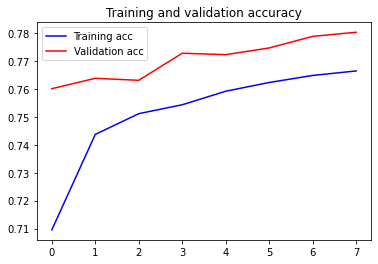

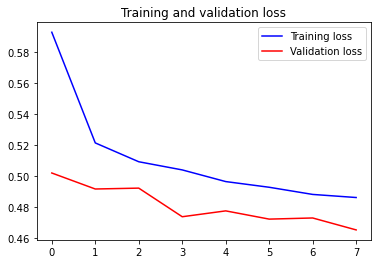

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Predict

In [35]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [36]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [37]:
predict("I love the music")

{'label': 'POSITIVE',
 'score': 0.9753027558326721,
 'elapsed_time': 0.3749961853027344}

In [38]:
predict("I hate the rain")

{'label': 'NEGATIVE',
 'score': 0.013321682810783386,
 'elapsed_time': 0.040999650955200195}

In [39]:
predict("i don't know what i'm doing")

{'label': 'NEUTRAL',
 'score': 0.46484920382499695,
 'elapsed_time': 0.04199981689453125}

### Confusion Matrix

In [40]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=1024)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

313/313 [==============================] - 30s 93ms/step
Wall time: 30.2 s


In [41]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

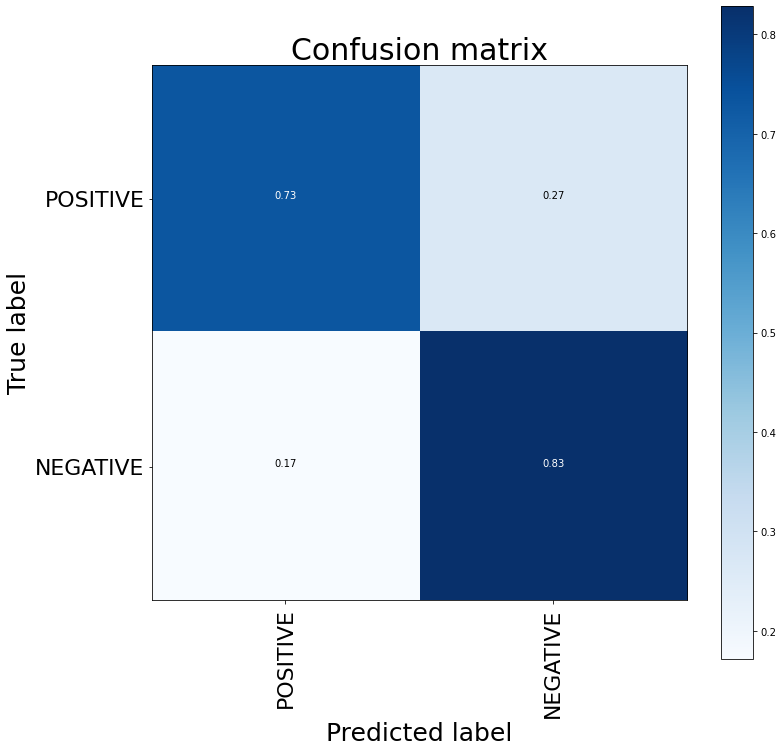

Wall time: 1.03 s


In [42]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [43]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.81      0.73      0.77    159494
    POSITIVE       0.76      0.83      0.79    160506

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



### Accuracy Score

In [44]:
accuracy_score(y_test_1d, y_pred_1d)

0.780403125

### Save model

In [45]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2021-06-26 20:13:41,779 : INFO : Word2Vec lifecycle event {'fname_or_handle': 'model.w2v', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-06-26T20:13:41.779721', 'gensim': '4.0.1', 'python': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'saving'}
2021-06-26 20:13:41,781 : INFO : not storing attribute cum_table
2021-06-26 20:13:41,908 : INFO : saved model.w2v
